11:06:05 - cmdstanpy - INFO - Chain [1] start processing
11:06:07 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE) of the hybrid model: 7615.227682978783


C:\Users\User\AppData\Local\Temp\ipykernel_17340\4196112891.py:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1] = future_pred_residual  # Add the new predicted residual


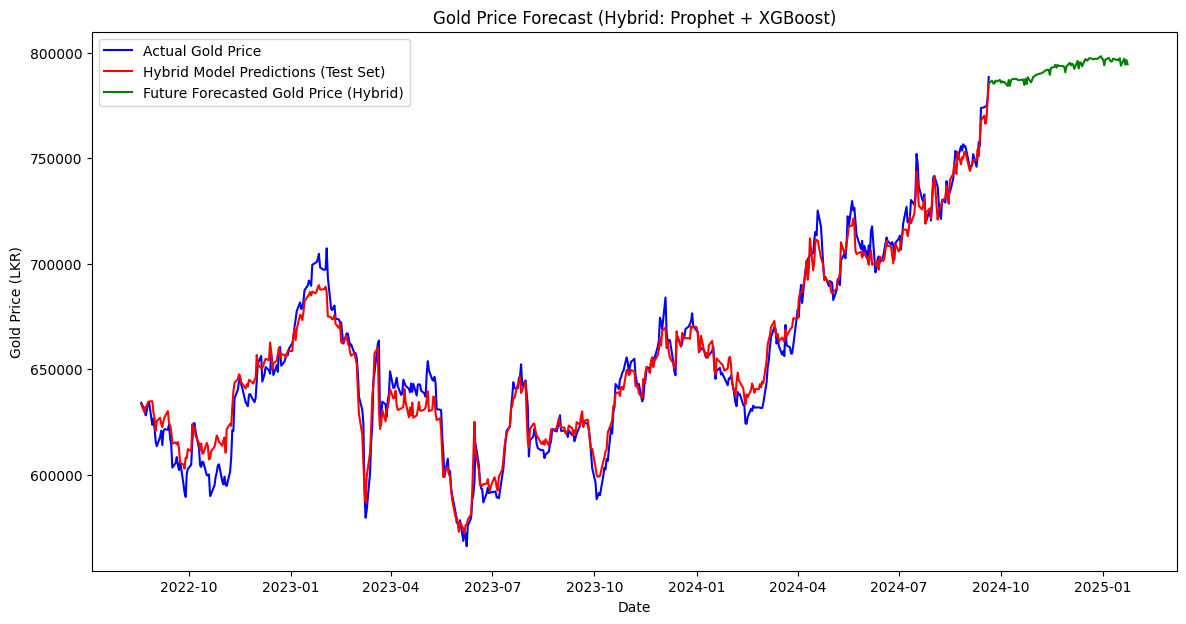

Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.


In [17]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# ,date,gold_lkr,gold_price_usd,silver_price,s&p_500_index,nyse_com_index,usd_selling_exrate,gold_futures,effr

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate','gold_futures','effr']

# Initialize and fit the Prophet model to capture the trend and seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Add each independent variable as a regressor in Prophet
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the Prophet model on the training data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions using the Prophet model
df_forecast = prophet_model.predict(df[['ds'] + regressors])

# Calculate the residuals (actual - predicted by Prophet)
df['residuals'] = df['y'] - df_forecast['yhat']

# use the residuals as the target variable for XGBoost
# Add lag features for XGBoost to help model temporal relationships
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create lag features for the residuals
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for XGBoost (we are predicting the residuals)
X = df.drop(columns=['ds', 'y', 'residuals'])
y = df['residuals']

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize and train the XGBoost model on the residuals
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.0001, max_depth=20)
xgb_model.fit(X_train, y_train)

# Predict the residuals on the test set
residuals_pred = xgb_model.predict(X_test)

# Combine Prophet's predictions with XGBoost's predictions of the residuals
# Predict using Prophet model for the test period
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Final predictions are Prophet's predictions + XGBoost's predicted residuals
final_predictions = prophet_test_predictions + residuals_pred

# Calculate the RMSE to evaluate the combined model's performance
actual_test_values = df['y'].iloc[train_size:]
rmse = np.sqrt(mean_squared_error(actual_test_values, final_predictions))
print(f'Root Mean Squared Error (RMSE) of the hybrid model: {rmse}')

# Forecasting future prices
# Forecast using Prophet for the next 30 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for the future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for the future dates
prophet_future_forecast = prophet_model.predict(future)

# Use XGBoost to predict the residuals for future dates
# Since XGBoost was trained on lagged residuals, we need to simulate future lags
last_sequence = np.array(X.iloc[-1, :])

# Function to make future predictions of residuals
def make_future_residual_predictions(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        # Predict residual using XGBoost
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0])
        
        # Update the sequence with the new predicted residual, shift the lags
        current_seq = np.roll(current_seq, -1)  # Shift the lag values
        current_seq[-1] = future_pred_residual  # Add the new predicted residual

    return future_residuals

# Predict residuals for the next 30 days
future_residuals_pred = make_future_residual_predictions(last_sequence, xgb_model, num_predictions=90)

# Combine Prophet's future predictions with XGBoost's residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Plot actual, hybrid model predictions, and future predictions on the same plot
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_test_values, label='Actual Gold Price', color='blue')

# Plot hybrid model predictions (Prophet + XGBoost) for the test set
plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the test set predictions and future predictions to CSV
# Create a DataFrame for test set predictions
test_results = pd.DataFrame({
    'date': df['ds'].iloc[train_size:],  # Test set dates
    'actual_gold_lkr': actual_test_values,
    'predicted_gold_lkr': final_predictions
})

# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'date': future['ds'],  # Future dates
    'predicted_gold_lkr': future_predictions
})

# Combine both DataFrames into one for exporting
combined_results = pd.concat([test_results, future_results], ignore_index=True)

# Save the results to a CSV file
combined_results.to_csv('hybrid_forecast_results_v02.csv', index=False)

# Confirm the file has been saved
print("Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.")




14:02:12 - cmdstanpy - INFO - Chain [1] start processing
14:02:14 - cmdstanpy - INFO - Chain [1] done processing


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters from GridSearchCV: {'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 500}
Root Mean Squared Error (RMSE) of the hybrid model: 10138.857784559366


C:\Users\User\AppData\Local\Temp\ipykernel_17340\3059273235.py:124: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1] = future_pred_residual


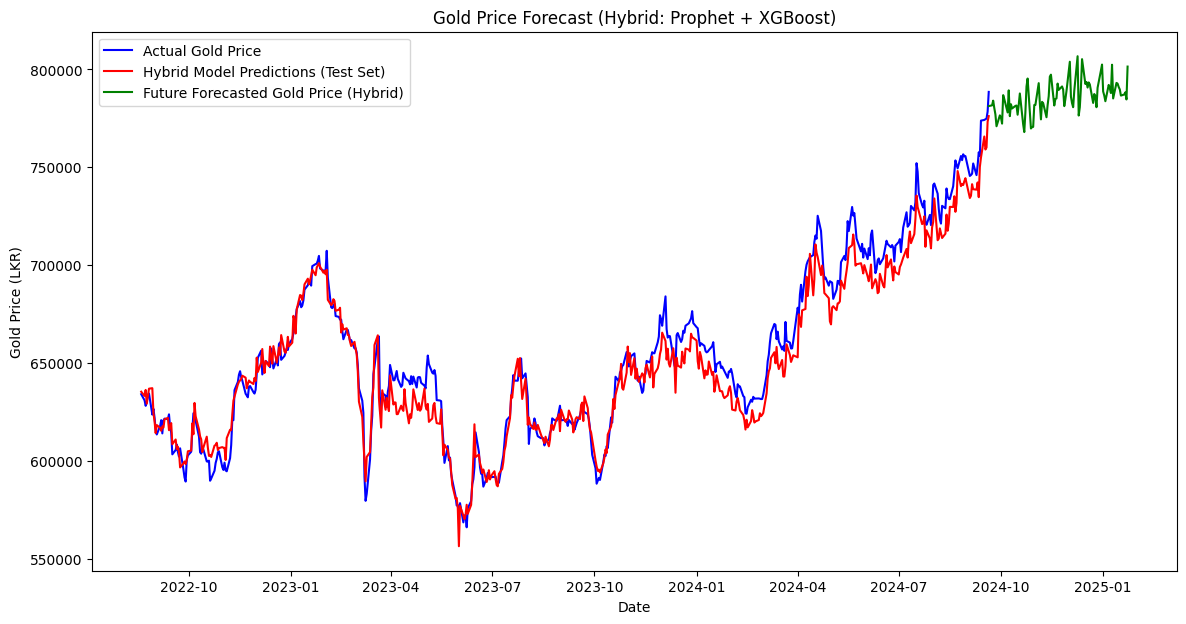

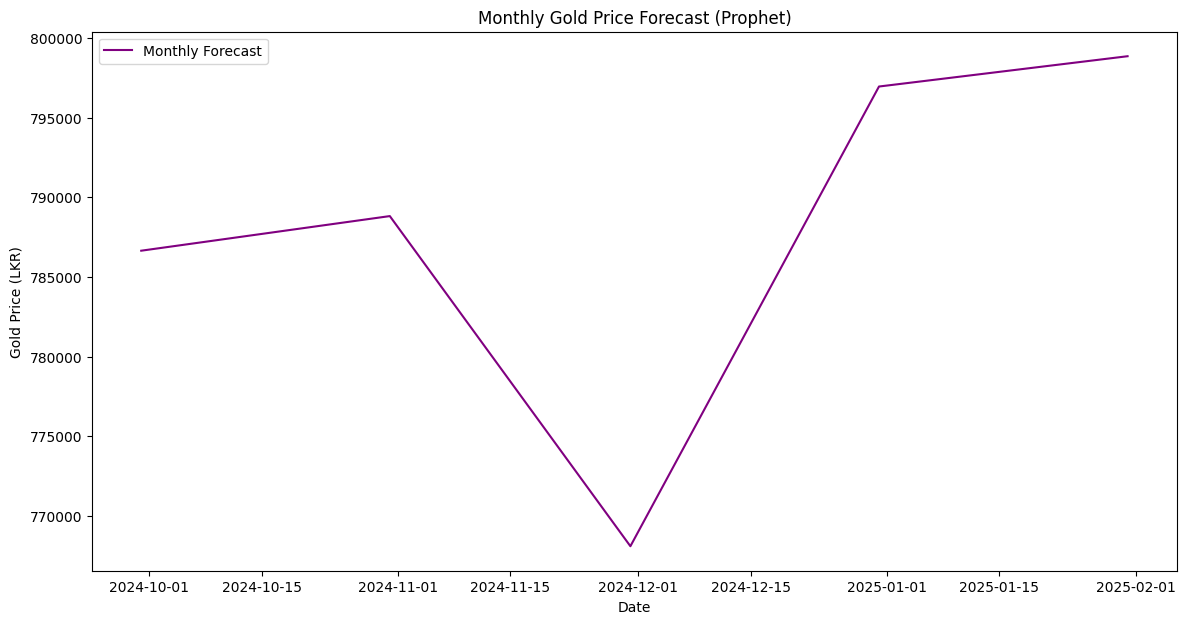

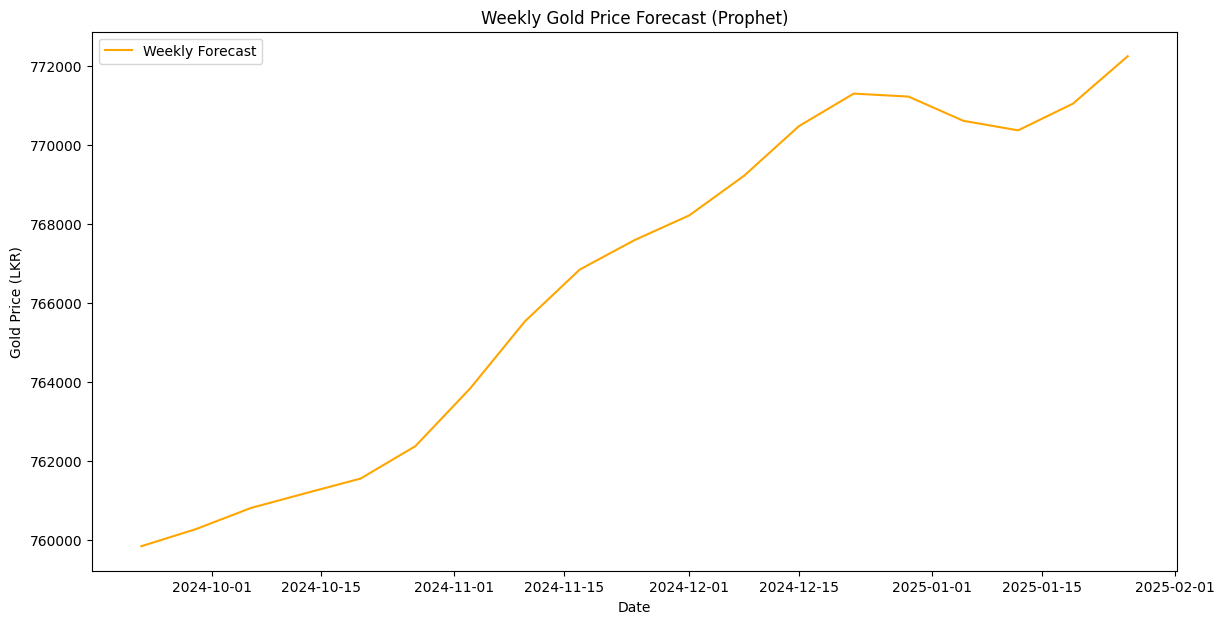

Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.


In [19]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Initialize and fit the Prophet model to capture the trend and seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Add each independent variable as a regressor in Prophet
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the Prophet model on the training data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions using the Prophet model
df_forecast = prophet_model.predict(df[['ds'] + regressors])

# Calculate the residuals (actual - predicted by Prophet)
df['residuals'] = df['y'] - df_forecast['yhat']

# use the residuals as the target variable for XGBoost
# Add lag features for XGBoost to help model temporal relationships
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create lag features for the residuals
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for XGBoost (we are predicting the residuals)
X = df.drop(columns=['ds', 'y', 'residuals'])
y = df['residuals']

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1500],
    'min_child_weight': [1, 5, 10],
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from GridSearch
print(f'Best parameters from GridSearchCV: {grid_search.best_params_}')

# Use the best parameters to train the model
xgb_model = xgb.XGBRegressor(**grid_search.best_params_)
xgb_model.fit(X_train_scaled, y_train)

# Predict the residuals on the test set
residuals_pred = xgb_model.predict(X_test_scaled)

# Combine Prophet's predictions with XGBoost's predictions of the residuals
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Final predictions are Prophet's predictions + XGBoost's predicted residuals
final_predictions = prophet_test_predictions + residuals_pred

# Calculate the RMSE to evaluate the combined model's performance
actual_test_values = df['y'].iloc[train_size:]
rmse = np.sqrt(mean_squared_error(actual_test_values, final_predictions))
print(f'Root Mean Squared Error (RMSE) of the hybrid model: {rmse}')

# Forecasting future prices
# Forecast using Prophet for the next 30 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for the future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for the future dates
prophet_future_forecast = prophet_model.predict(future)

# Use XGBoost to predict the residuals for future dates
last_sequence = np.array(X.iloc[-1, :])

# Function to make future predictions of residuals
def make_future_residual_predictions(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0])
        
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = future_pred_residual

    return future_residuals

# Predict residuals for the next 30 days
future_residuals_pred = make_future_residual_predictions(last_sequence, xgb_model, num_predictions=90)

# Combine Prophet's future predictions with XGBoost's residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Plot actual, hybrid model predictions, and future predictions
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_test_values, label='Actual Gold Price', color='blue')

# Plot hybrid model predictions (Prophet + XGBoost) for the test set
plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# # --- Additional Plotting for Monthly and Weekly Forecasts ---
# # Monthly Forecast
# monthly_forecast = prophet_model.predict(future.resample('M', on='ds').first())
# plt.figure(figsize=(14, 7))
# plt.plot(monthly_forecast['ds'], monthly_forecast['yhat'], label='Monthly Forecast', color='purple')
# plt.title('Monthly Gold Price Forecast (Prophet)')
# plt.xlabel('Date')
# plt.ylabel('Gold Price (LKR)')
# plt.legend()
# plt.show()

# # Weekly Forecast
# weekly_forecast = prophet_model.predict(future.resample('W', on='ds').first())
# plt.figure(figsize=(14, 7))
# plt.plot(weekly_forecast['ds'], weekly_forecast['yhat'], label='Weekly Forecast', color='orange')
# plt.title('Weekly Gold Price Forecast (Prophet)')
# plt.xlabel('Date')
# plt.ylabel('Gold Price (LKR)')
# plt.legend()
# plt.show()

# --- Additional Plotting for Monthly and Weekly Forecasts ---

# Set 'ds' as the index for the future DataFrame to allow resampling
future.set_index('ds', inplace=True)

# Monthly Forecast
monthly_future = future.resample('M').first().reset_index()  # Resample monthly and reset index
monthly_forecast = prophet_model.predict(monthly_future)

plt.figure(figsize=(14, 7))
plt.plot(monthly_forecast['ds'], monthly_forecast['yhat'], label='Monthly Forecast', color='purple')
plt.title('Monthly Gold Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Weekly Forecast
weekly_future = future.resample('W').first().reset_index()  # Resample weekly and reset index
weekly_forecast = prophet_model.predict(weekly_future)

plt.figure(figsize=(14, 7))
plt.plot(weekly_forecast['ds'], weekly_forecast['yhat'], label='Weekly Forecast', color='orange')
plt.title('Weekly Gold Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()


# Save the results to a CSV file
combined_results.to_csv('hybrid_forecast_results_v02.csv', index=False)
print("Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.")


KeyError: 'ds'

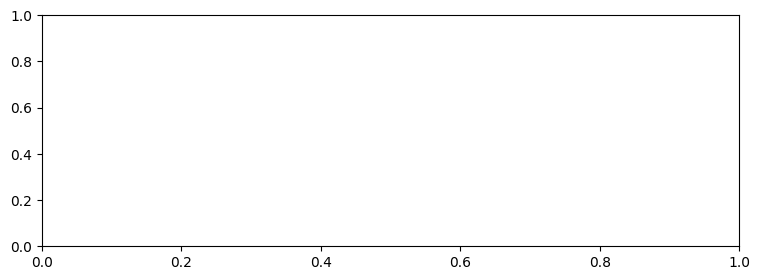

In [20]:
fig = prophet_model.plot_components(future)

10:17:44 - cmdstanpy - INFO - Chain [1] start processing
10:17:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


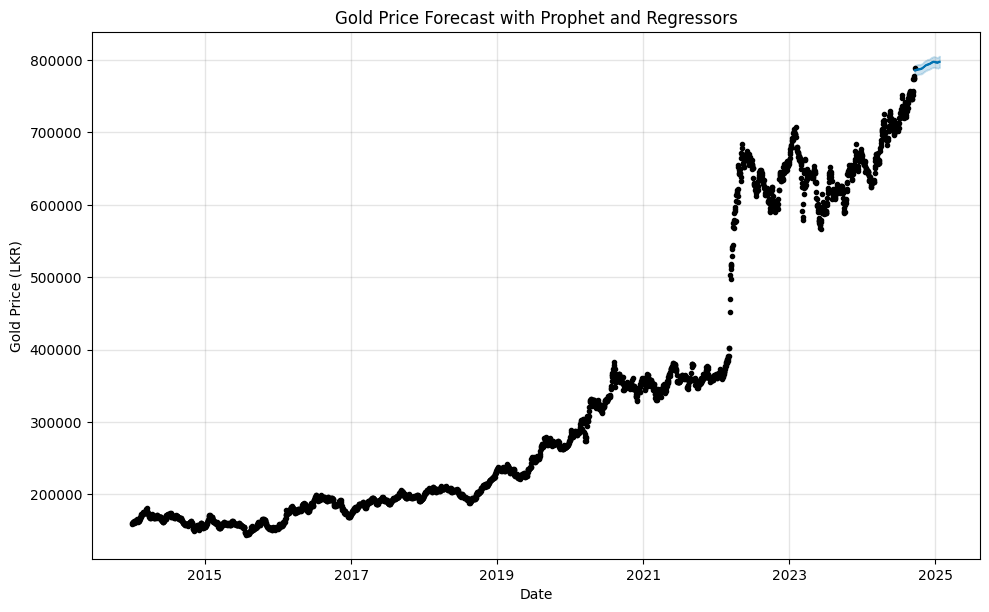

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

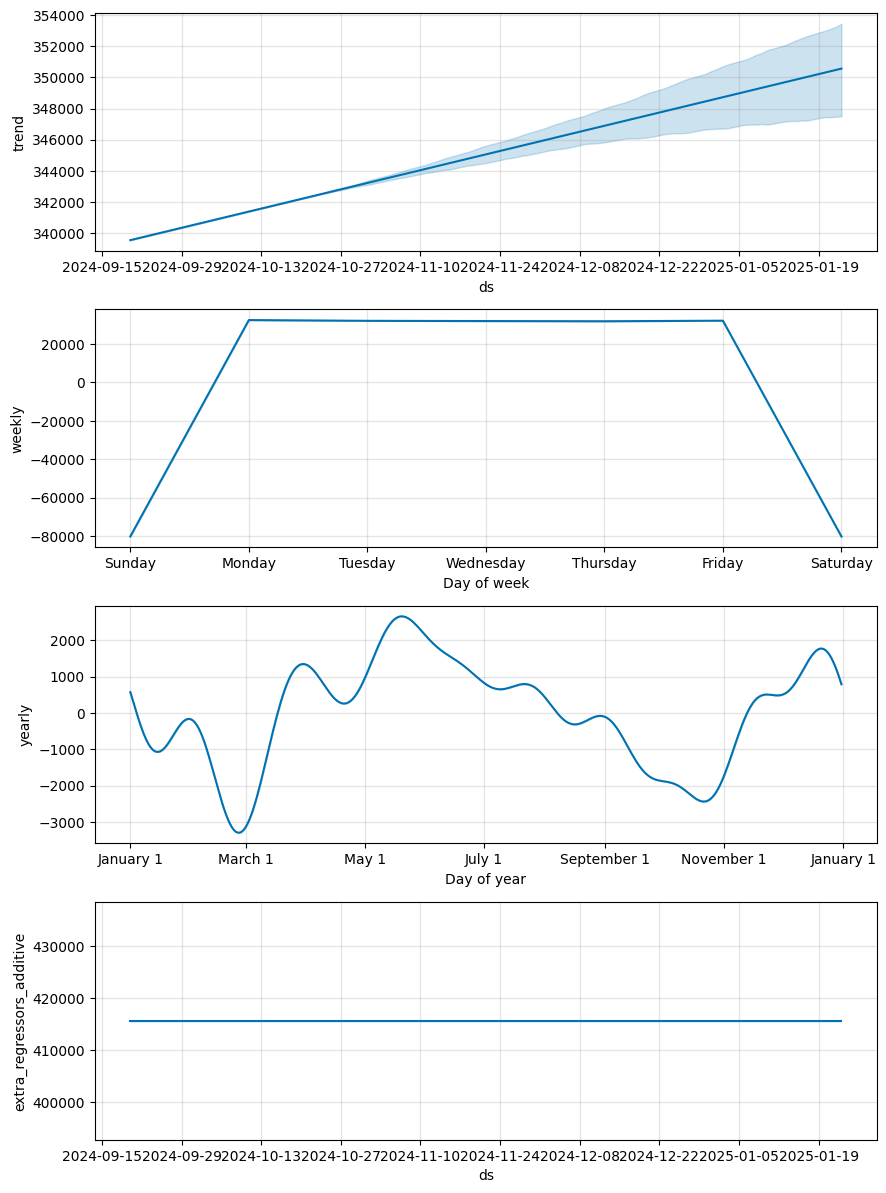

Exception: Prophet object can only be fit once. Instantiate a new object.

In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # Update with your dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename 'date' and 'gold_lkr' columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables

regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate','gold_futures','effr']

# Initialize the Prophet model
model = Prophet()

# Add each independent variable as a regressor
for regressor in regressors:
    model.add_regressor(regressor)

# Train the model
model.fit(df[['ds', 'y'] + regressors])

# Forecast for the next 30 business days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the most recent values of the regressors to project future values
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Make future predictions
forecast = model.predict(future)

# Visualize the forecast
model.plot(forecast)
plt.title('Gold Price Forecast with Prophet and Regressors')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.show()

# Visualize the components (trend, weekly, yearly)
model.plot_components(forecast)
plt.show()

# Evaluate accuracy on historical data by splitting the dataset into train and test sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Train the model on the training set
model.fit(train_df[['ds', 'y'] + regressors])

# Make predictions for the test set
future_test = test_df[['ds'] + regressors]
forecast_test = model.predict(future_test)

# Calculate performance metrics (like MSE or RMSE) for evaluation
test_actuals = test_df['y']
test_predictions = forecast_test['yhat']
mse = mean_squared_error(test_actuals, test_predictions)
rmse = mse ** 0.5

print(f'Root Mean Squared Error (RMSE) on the test set: {rmse}')

# If you want to see the future predictions, they are stored in `forecast`
# You can access the forecasted values using: `forecast[['ds', 'yhat']]`


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
09:35:32 - cmdstanpy - INFO - Chain [1] start processing
09:35:33 - cmdstanpy - INFO - Chain [1] done processing


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters from GridSearchCV: {'learning_rate': 0.01, 'max_depth': 15, 'min_child_weight': 10, 'n_estimators': 500}
Root Mean Squared Error (RMSE) of the hybrid model: 10138.857784559366


C:\Users\User\AppData\Local\Temp\ipykernel_3052\3179683648.py:124: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1] = future_pred_residual


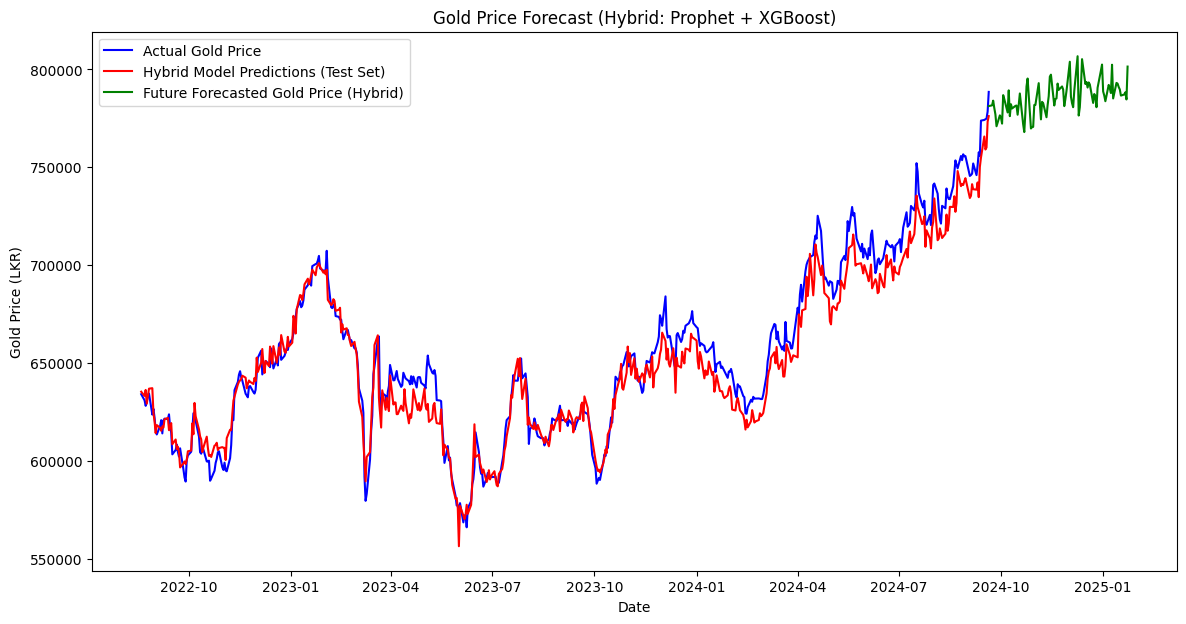

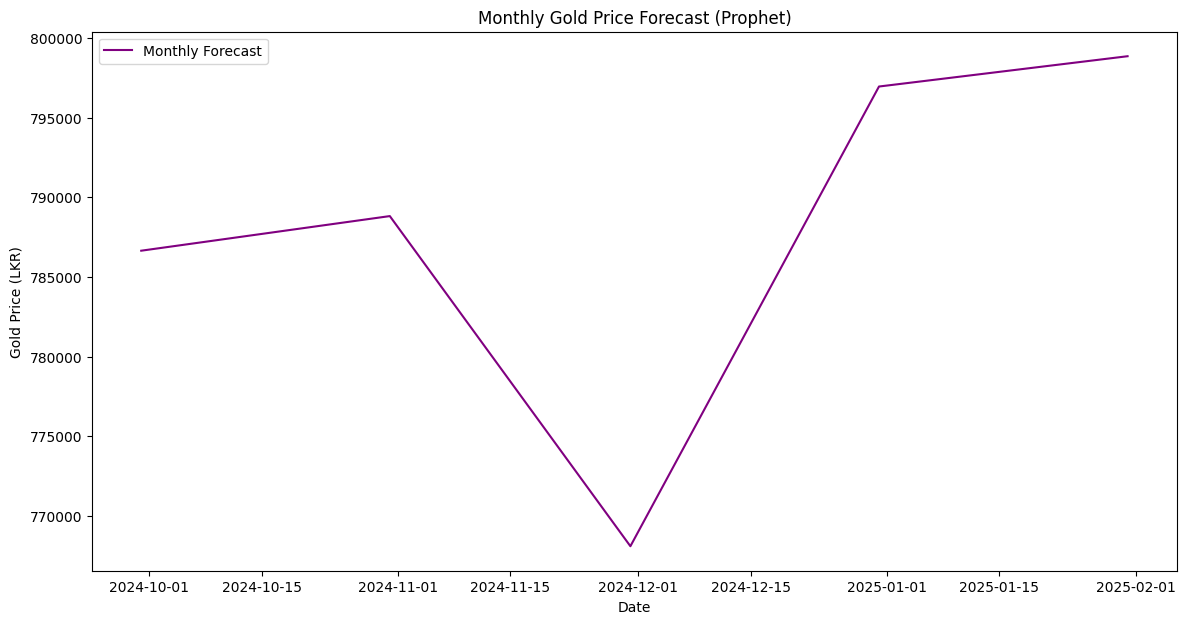

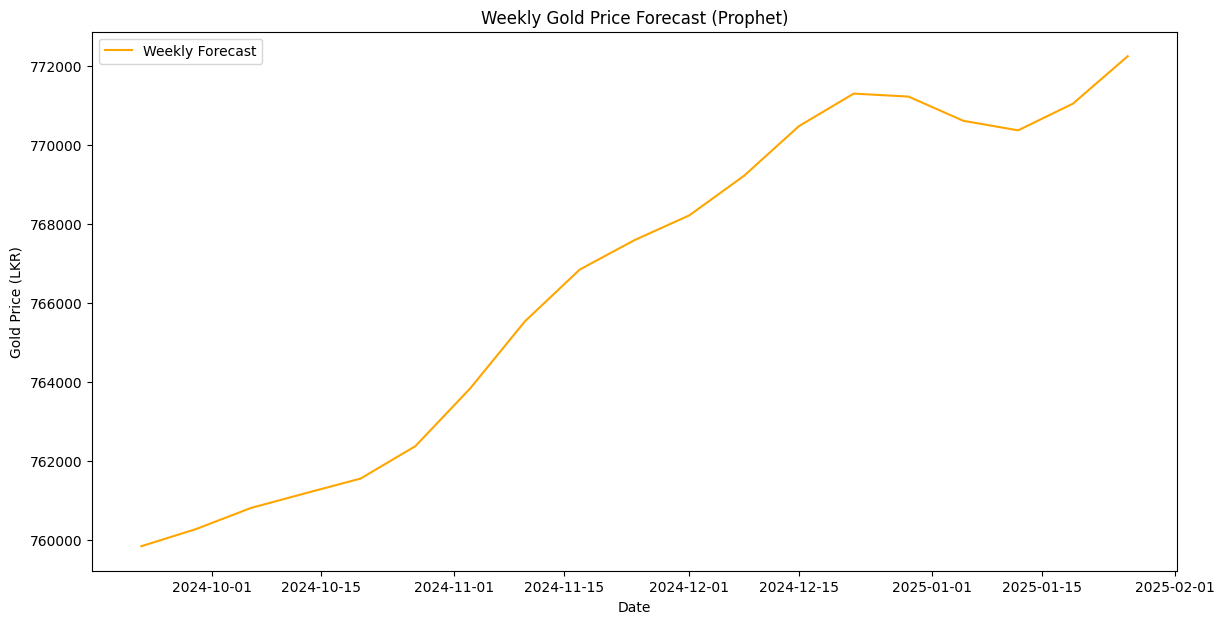

Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.


In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Initialize and fit the Prophet model to capture the trend and seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Add each independent variable as a regressor in Prophet
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the Prophet model on the training data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions using the Prophet model
df_forecast = prophet_model.predict(df[['ds'] + regressors])

# Calculate the residuals (actual - predicted by Prophet)
df['residuals'] = df['y'] - df_forecast['yhat']

# Use the residuals as the target variable for XGBoost
# Add lag features for XGBoost to help model temporal relationships
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create lag features for the residuals
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for XGBoost (we are predicting the residuals)
X = df.drop(columns=['ds', 'y', 'residuals'])
y = df['residuals']

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1500],
    'min_child_weight': [1, 5, 10],
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from GridSearch
print(f'Best parameters from GridSearchCV: {grid_search.best_params_}')

# Use the best parameters to train the model
xgb_model = xgb.XGBRegressor(**grid_search.best_params_)
xgb_model.fit(X_train_scaled, y_train)

# Predict the residuals on the test set
residuals_pred = xgb_model.predict(X_test_scaled)

# Combine Prophet's predictions with XGBoost's predictions of the residuals
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Final predictions are Prophet's predictions + XGBoost's predicted residuals
final_predictions = prophet_test_predictions + residuals_pred

# Calculate the RMSE to evaluate the combined model's performance
actual_test_values = df['y'].iloc[train_size:]
rmse = np.sqrt(mean_squared_error(actual_test_values, final_predictions))
print(f'Root Mean Squared Error (RMSE) of the hybrid model: {rmse}')

# Forecasting future prices
# Forecast using Prophet for the next 30 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for the future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for the future dates
prophet_future_forecast = prophet_model.predict(future)

# Use XGBoost to predict the residuals for future dates
last_sequence = np.array(X.iloc[-1, :])

# Function to make future predictions of residuals
def make_future_residual_predictions(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0])
        
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = future_pred_residual

    return future_residuals

# Predict residuals for the next 30 days
future_residuals_pred = make_future_residual_predictions(last_sequence, xgb_model, num_predictions=90)

# Combine Prophet's future predictions with XGBoost's residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Plot actual, hybrid model predictions, and future predictions
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_test_values, label='Actual Gold Price', color='blue')

# Plot hybrid model predictions (Prophet + XGBoost) for the test set
plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# --- Additional Plotting for Monthly and Weekly Forecasts ---

# Set 'ds' as the index for the future DataFrame to allow resampling
future.set_index('ds', inplace=True)

# Monthly Forecast
monthly_future = future.resample('M').first().reset_index()  # Resample monthly and reset index
monthly_forecast = prophet_model.predict(monthly_future)

plt.figure(figsize=(14, 7))
plt.plot(monthly_forecast['ds'], monthly_forecast['yhat'], label='Monthly Forecast', color='purple')
plt.title('Monthly Gold Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Weekly Forecast
weekly_future = future.resample('W').first().reset_index()  # Resample weekly and reset index
weekly_forecast = prophet_model.predict(weekly_future)

plt.figure(figsize=(14, 7))
plt.plot(weekly_forecast['ds'], weekly_forecast['yhat'], label='Weekly Forecast', color='orange')
plt.title('Weekly Gold Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the results to a CSV file
combined_results = pd.DataFrame({
    'Date': future_dates,
    'Prophet_Prediction': prophet_future_forecast['yhat'],
    'XGBoost_Residuals': future_residuals_pred,
    'Hybrid_Prediction': future_predictions
})

combined_results.to_csv('hybrid_forecast_results_v02.csv', index=False)
print("Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.")


## ----------------------------------------------------------------------

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters from GridSearchCV: {'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 500}
Root Mean Squared Error (RMSE) of the hybrid model: 10207.36323864975


C:\Users\User\AppData\Local\Temp\ipykernel_10288\232659094.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1] = future_pred_residual


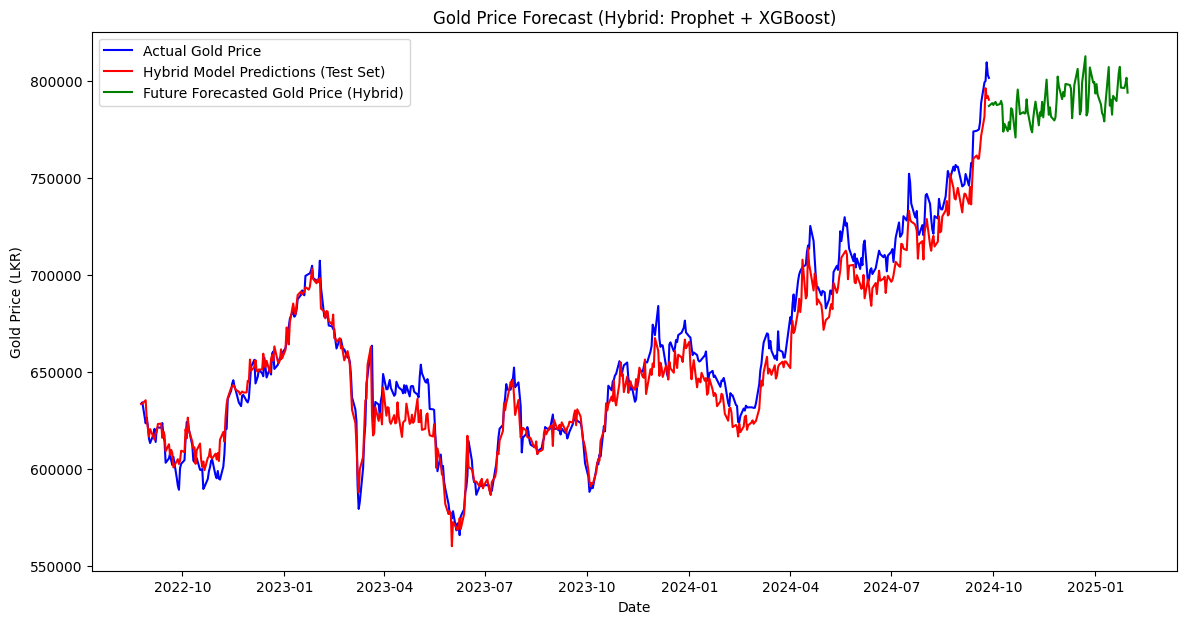

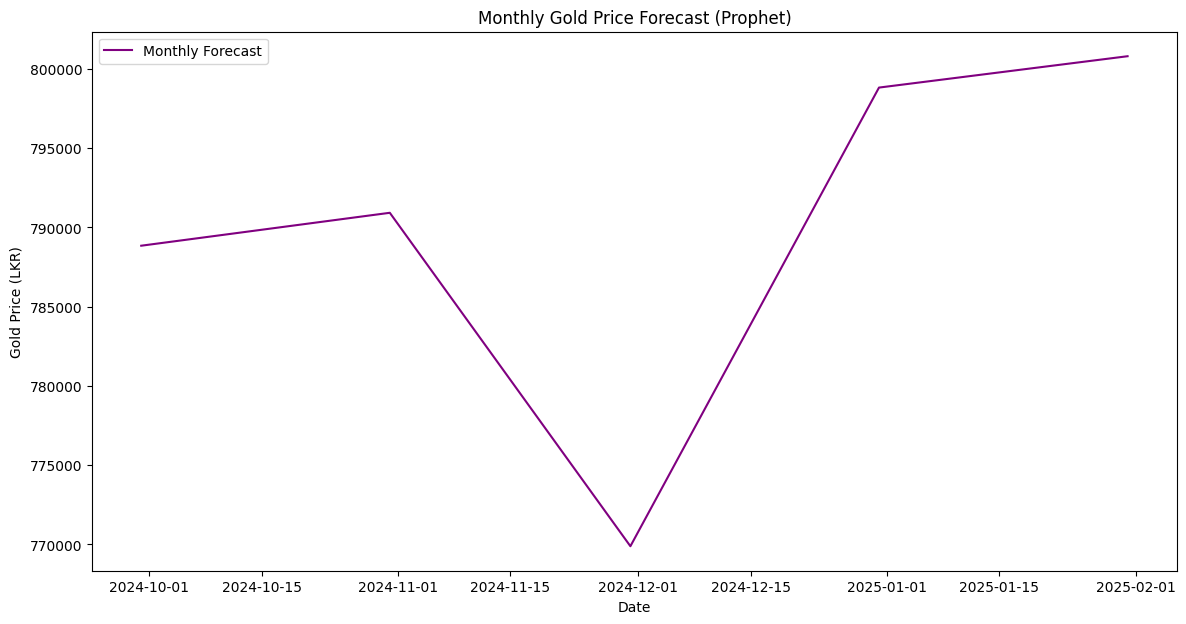

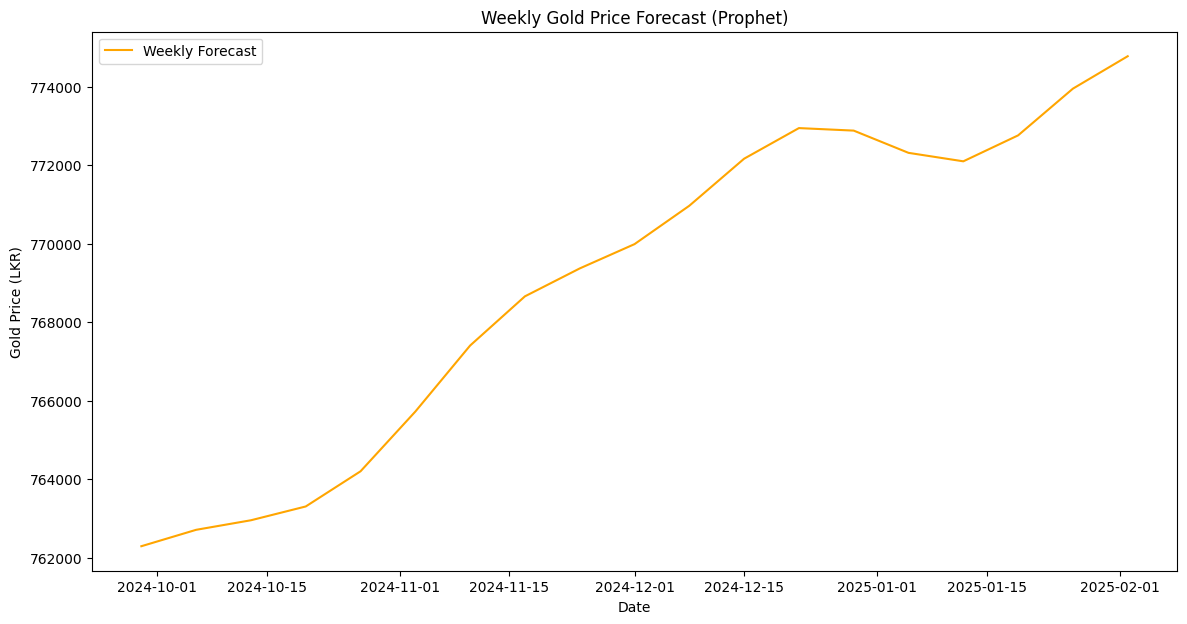

Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.


In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (3).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Initialize and fit the Prophet model to capture the trend and seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Add each independent variable as a regressor in Prophet
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the Prophet model on the training data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions using the Prophet model
df_forecast = prophet_model.predict(df[['ds'] + regressors])

# Calculate the residuals (actual - predicted by Prophet)
df['residuals'] = df['y'] - df_forecast['yhat']

# Create lag features for the residuals for a 90-day sliding window
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create lag features for the residuals
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for XGBoost (we are predicting the residuals)
X = df.drop(columns=['ds', 'y', 'residuals'])
y = df['residuals']

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning using GridSearchCV for XGBoost
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],
    'max_depth': [10, 15, 20],
    'n_estimators': [500, 1000, 1500],
    'min_child_weight': [1, 5, 10],
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters from GridSearch
print(f'Best parameters from GridSearchCV: {grid_search.best_params_}')

# Use the best parameters to train the XGBoost model
xgb_model = xgb.XGBRegressor(**grid_search.best_params_)
xgb_model.fit(X_train_scaled, y_train)

# Predict the residuals on the test set
residuals_pred = xgb_model.predict(X_test_scaled)

# Combine Prophet's predictions with XGBoost's predictions of the residuals
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Final predictions are Prophet's predictions + XGBoost's predicted residuals
final_predictions = prophet_test_predictions + residuals_pred

# Calculate the RMSE to evaluate the combined model's performance
actual_test_values = df['y'].iloc[train_size:]
rmse = np.sqrt(mean_squared_error(actual_test_values, final_predictions))
print(f'Root Mean Squared Error (RMSE) of the hybrid model: {rmse}')

# Forecasting future prices
# Forecast using Prophet for the next 90 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for the future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for the future dates
prophet_future_forecast = prophet_model.predict(future)

# Function to make future predictions of residuals using XGBoost
def make_future_residual_predictions(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0])
        
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = future_pred_residual

    return future_residuals

# Predict residuals for the next 90 days
last_sequence = np.array(X.iloc[-1, :])
future_residuals_pred = make_future_residual_predictions(last_sequence, xgb_model, num_predictions=90)

# Combine Prophet's future predictions with XGBoost's residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Plot actual, hybrid model predictions, and future predictions
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_test_values, label='Actual Gold Price', color='blue')

# Plot hybrid model predictions (Prophet + XGBoost) for the test set
plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# --- Additional Plotting for Monthly and Weekly Forecasts ---

# Set 'ds' as the index for the future DataFrame to allow resampling
future.set_index('ds', inplace=True)

# Monthly Forecast
monthly_future = future.resample('M').first().reset_index()  # Resample monthly and reset index
monthly_forecast = prophet_model.predict(monthly_future)

plt.figure(figsize=(14, 7))
plt.plot(monthly_forecast['ds'], monthly_forecast['yhat'], label='Monthly Forecast', color='purple')
plt.title('Monthly Gold Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Weekly Forecast
weekly_future = future.resample('W').first().reset_index()  # Resample weekly and reset index
weekly_forecast = prophet_model.predict(weekly_future)

plt.figure(figsize=(14, 7))
plt.plot(weekly_forecast['ds'], weekly_forecast['yhat'], label='Weekly Forecast', color='orange')
plt.title('Weekly Gold Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the results to a CSV file
combined_results = pd.DataFrame({
    'Date': future_dates,
    'Prophet_Prediction': prophet_future_forecast['yhat'],
    'XGBoost_Residuals': future_residuals_pred,
    'Hybrid_Prediction': future_predictions
})

combined_results.to_csv('hybrid_forecast_results_v02.csv', index=False)
print("Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.")


## FILE SAVE

In [3]:
import joblib
import os

# Create a directory to save the model files
model_dir = "model_files"
os.makedirs(model_dir, exist_ok=True)

# Save the Prophet model using joblib
joblib.dump(prophet_model, os.path.join(model_dir, "prophet_model.pkl"))

# Save the XGBoost model
xgb_model.save_model(os.path.join(model_dir, "xgb_model.json"))

# Save the StandardScaler
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))

# Save the regressor names
joblib.dump(regressors, os.path.join(model_dir, "regressors.pkl"))

print("All necessary files for prediction have been saved in the 'model_files' directory.")


All necessary files for prediction have been saved in the 'model_files' directory.


## MAKE Pred

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from prophet import Prophet
import joblib
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset
df = pd.read_csv('df_interpolated (3).csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Log dataset information
logging.info(f"Dataset loaded with {len(df)} rows.")

# Directory where models are saved
model_dir = "model_files"

# Load the saved Prophet model
prophet_model = joblib.load(os.path.join(model_dir, "prophet_model.pkl"))
logging.info("Prophet model loaded successfully.")

# Load the saved XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(os.path.join(model_dir, "xgb_model.json"))
logging.info("XGBoost model loaded successfully.")

# Load the saved StandardScaler
scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
logging.info("Scaler loaded successfully.")

# Load the regressors
regressors = joblib.load(os.path.join(model_dir, "regressors.pkl"))
logging.info("Regressors loaded successfully: %s", regressors)

# Prepare the regressor variables for the entire dataset
df_forecast = prophet_model.predict(df[['ds'] + regressors])
logging.info("Prophet model made predictions for the entire dataset.")

# Create lag features for the residuals
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Compute residuals (y - Prophet predictions)
df['residuals'] = df['y'] - df_forecast['yhat']

# Create 90-day lag features
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)
logging.info(f"After creating lag features, dataset has {len(df)} rows.")

# Prepare features (X) for XGBoost
X = df.drop(columns=['ds', 'y', 'residuals'])

# Scale the features
X_scaled = scaler.transform(X)
logging.info("Features have been scaled for XGBoost model.")

# Predict residuals using the XGBoost model
residuals_pred = xgb_model.predict(X_scaled)
logging.info("XGBoost model made residual predictions.")

# Adjust the df_forecast to account for the 90-day lag
df_forecast_lagged = df_forecast.iloc[90:].reset_index(drop=True)

# Ensure the number of Prophet predictions matches the number of residual predictions
if len(df_forecast_lagged['yhat']) != len(residuals_pred):
    logging.error("Length mismatch: Prophet predictions vs. XGBoost residuals")
    raise ValueError(f"Length mismatch: Prophet predictions ({len(df_forecast_lagged['yhat'])}) vs. XGBoost residuals ({len(residuals_pred)})")

# Combine Prophet's predictions with XGBoost's predicted residuals
final_predictions = df_forecast_lagged['yhat'] + residuals_pred
logging.info("Final hybrid predictions (Prophet + XGBoost) computed.")

# Save the forecasted values along with the respective dates (adjust dates for the lag)
forecast_results = pd.DataFrame({
    'Date': df['ds'].iloc[90:].reset_index(drop=True),
    'Prophet_Prediction': df_forecast_lagged['yhat'],
    'XGBoost_Residuals': residuals_pred,
    'Hybrid_Prediction': final_predictions
})

# Save the forecast results to CSV
forecast_results.to_csv('forecast_results_FULL_v02.csv', index=False)
logging.info("Forecasted values have been saved to 'hybrid_forecast_results_v02.csv'.")


2024-09-30 15:42:15,108 - INFO - Dataset loaded with 2797 rows.
2024-09-30 15:42:15,119 - INFO - Prophet model loaded successfully.
2024-09-30 15:42:15,225 - INFO - XGBoost model loaded successfully.
2024-09-30 15:42:15,230 - INFO - Scaler loaded successfully.
2024-09-30 15:42:15,231 - INFO - Regressors loaded successfully: ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']
2024-09-30 15:42:15,480 - INFO - Prophet model made predictions for the entire dataset.
2024-09-30 15:42:15,494 - INFO - After creating lag features, dataset has 2707 rows.
2024-09-30 15:42:15,505 - INFO - Features have been scaled for XGBoost model.
2024-09-30 15:42:15,507 - INFO - XGBoost model made residual predictions.
2024-09-30 15:42:15,514 - INFO - Final hybrid predictions (Prophet + XGBoost) computed.
2024-09-30 15:42:15,517 - INFO - Forecasted values have been saved to 'hybrid_forecast_results_v02.csv'.


: 

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from prophet import Prophet
import joblib
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset
df = pd.read_csv('df_interpolated (3).csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Log dataset information
logging.info(f"Dataset loaded with {len(df)} rows.")

# Directory where models are saved
model_dir = "model_files"

# Load the saved Prophet model
prophet_model = joblib.load(os.path.join(model_dir, "prophet_model.pkl"))
logging.info("Prophet model loaded successfully.")

# Load the saved XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(os.path.join(model_dir, "xgb_model.json"))
logging.info("XGBoost model loaded successfully.")

# Load the saved StandardScaler
scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
logging.info("Scaler loaded successfully.")

# Load the regressors
regressors = joblib.load(os.path.join(model_dir, "regressors.pkl"))
logging.info("Regressors loaded successfully: %s", regressors)

# Prepare the regressor variables for the entire dataset
df_forecast = prophet_model.predict(df[['ds'] + regressors])
logging.info("Prophet model made predictions for the entire dataset.")

# Compute residuals (y - Prophet predictions)
df['residuals'] = df['y'] - df_forecast['yhat']

# Keep only the regressor columns for XGBoost (drop any lag or other unwanted columns)
X = df[regressors]

# Scale the features using the previously saved scaler
X_scaled = scaler.transform(X)
logging.info("Features have been scaled for XGBoost model.")

# Predict residuals using the XGBoost model
residuals_pred = xgb_model.predict(X_scaled)
logging.info("XGBoost model made residual predictions.")

# Combine Prophet's predictions with XGBoost's predicted residuals
final_predictions = df_forecast['yhat'] + residuals_pred
logging.info("Final hybrid predictions (Prophet + XGBoost) computed.")

# Save the forecasted values along with the respective dates
forecast_results = pd.DataFrame({
    'Date': df['ds'],
    'Prophet_Prediction': df_forecast['yhat'],
    'XGBoost_Residuals': residuals_pred,
    'Hybrid_Prediction': final_predictions
})

# Save the forecast results to CSV
forecast_results.to_csv('forecast_results_full_val.csv', index=False)
logging.info("Forecasted values have been saved to 'hybrid_forecast_results_v02.csv'.")


2024-09-30 15:41:40,309 - INFO - Dataset loaded with 2797 rows.
2024-09-30 15:41:40,313 - INFO - Prophet model loaded successfully.
2024-09-30 15:41:40,428 - INFO - XGBoost model loaded successfully.
2024-09-30 15:41:40,435 - INFO - Scaler loaded successfully.
2024-09-30 15:41:40,435 - INFO - Regressors loaded successfully: ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']
2024-09-30 15:41:40,679 - INFO - Prophet model made predictions for the entire dataset.


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Unnamed: 0
- lag_1
- lag_10
- lag_11
- lag_12
- ...


In [3]:
# # Plot hybrid model predictions (Prophet + XGBoost) for the test set
# plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Save the results to a CSV file
combined_results_02 = pd.DataFrame({
    'Date': df['ds'].iloc[train_size:],
    'Prediction': final_predictions
    #'XGBoost_Residuals': future_residuals_pred,
    #'Hybrid_Prediction': future_predictions
})

combined_results_02.to_csv('results_v02.csv', index=False)

Test set predictions have been saved to 'test_set_forecast_results.csv'.


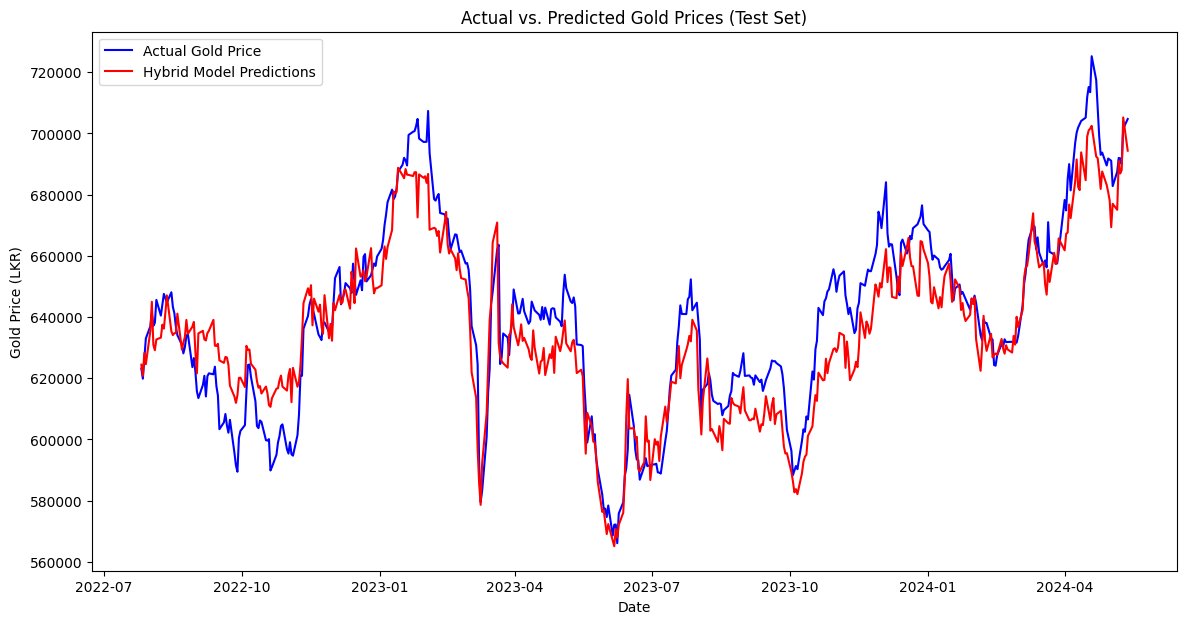

In [5]:
# Align Prophet's test predictions and XGBoost's residual predictions by checking their lengths
prophet_test_predictions = prophet_test_predictions[:len(residuals_pred)]  # Truncate to match the length of residuals

# Now they should have the same shape and we can combine them
final_test_predictions = prophet_test_predictions + residuals_pred

# Store the test set predictions in a DataFrame for recoding
test_results_df = pd.DataFrame({
    'Date': df['ds'].iloc[train_size:train_size + len(final_test_predictions)].values,
    'Actual_Gold_Price': df['y'].iloc[train_size:train_size + len(final_test_predictions)].values,
    'Prophet_Prediction': prophet_test_predictions,
    'XGBoost_Residuals': residuals_pred,
    'Hybrid_Prediction': final_test_predictions
})

# Save the test set predictions to a CSV file
test_results_df.to_csv('test_set_forecast_results.csv', index=False)
print("Test set predictions have been saved to 'test_set_forecast_results.csv'.")

# Optional: Plot the actual vs. predicted values for the test set
plt.figure(figsize=(14, 7))
plt.plot(test_results_df['Date'], test_results_df['Actual_Gold_Price'], label='Actual Gold Price', color='blue')
plt.plot(test_results_df['Date'], test_results_df['Hybrid_Prediction'], label='Hybrid Model Predictions', color='red')
plt.title('Actual vs. Predicted Gold Prices (Test Set)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()


Forecasted test set and future predictions have been saved to 'forecast_results_test_and_future.csv'.


C:\Users\User\AppData\Local\Temp\ipykernel_3052\2683049581.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1] = future_pred_residual


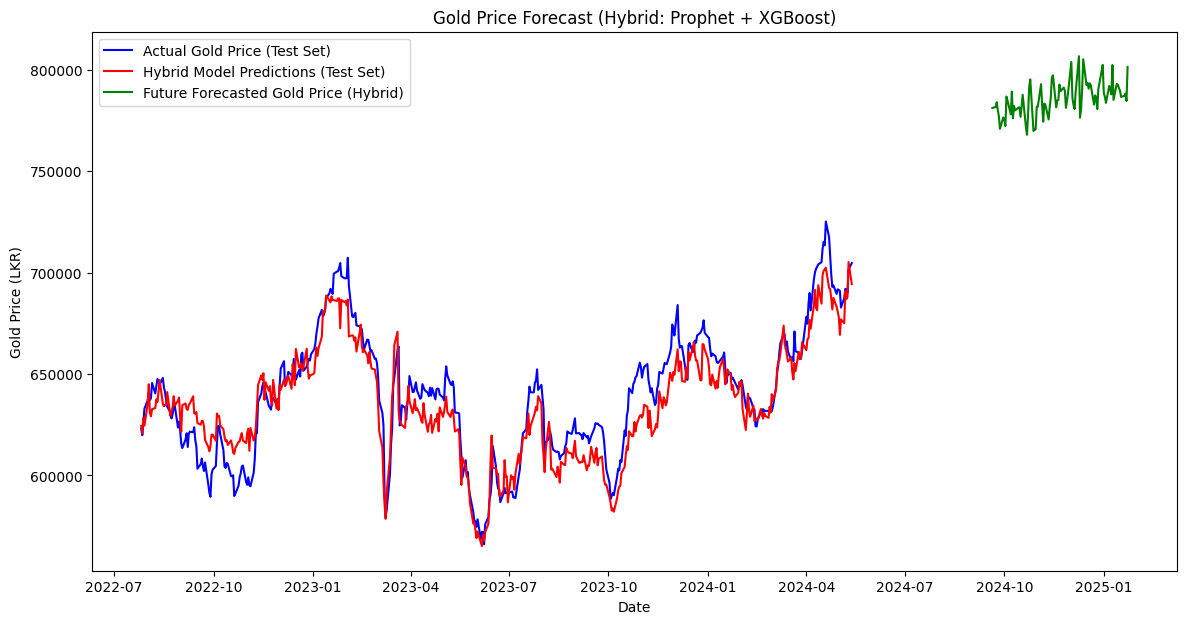

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume Prophet and XGBoost models have already been trained as in previous code.

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Regresor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Forecasting the test set
train_size = int(len(df) * 0.8)

# Predict Prophet forecast for the test set
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Predict residuals using XGBoost for the test set
X_test_scaled = scaler.transform(X[train_size:])
residuals_pred_test = xgb_model.predict(X_test_scaled)

# Align lengths of Prophet's and XGBoost's predictions
prophet_test_predictions = prophet_test_predictions[:len(residuals_pred_test)]  # Truncate to match residuals length

# Final test set predictions
final_test_predictions = prophet_test_predictions + residuals_pred_test

# Create a DataFrame for test set results
test_results_df = pd.DataFrame({
    'Date': df['ds'].iloc[train_size:train_size + len(final_test_predictions)].values,
    'Actual_Gold_Price': df['y'].iloc[train_size:train_size + len(final_test_predictions)].values,
    'Prophet_Prediction': prophet_test_predictions,
    'XGBoost_Residuals': residuals_pred_test,
    'Hybrid_Prediction': final_test_predictions
})

# ---- Future Forecasting ----

# Forecast future gold prices using Prophet for the next 90 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for future dates
prophet_future_forecast = prophet_model.predict(future)

# Function to make future predictions of residuals using XGBoost
def make_future_residual_predictions(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0])
        
        current_seq = np.roll(current_seq, -1)
        current_seq[-1] = future_pred_residual

    return future_residuals

# Predict residuals for the next 90 days
last_sequence = np.array(X.iloc[-1, :])
future_residuals_pred = make_future_residual_predictions(last_sequence, xgb_model, num_predictions=90)

# Combine Prophet's future predictions with XGBoost's future residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Create a DataFrame for future results
future_results_df = pd.DataFrame({
    'Date': future_dates,
    'Prophet_Prediction': prophet_future_forecast['yhat'],
    'XGBoost_Residuals': future_residuals_pred,
    'Hybrid_Prediction': future_predictions
})

# ---- Save Test Set and Future Results to CSV ----

# Combine both test and future results into one DataFrame
combined_results = pd.concat([test_results_df, future_results_df], ignore_index=True)

# Save combined results to a CSV file
combined_results.to_csv('forecast_results_test_and_future.csv', index=False)
print("Forecasted test set and future predictions have been saved to 'forecast_results_test_and_future.csv'.")

# ---- Plotting ----

# Plot the actual vs. predicted values for the test set and future forecast
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(test_results_df['Date'], test_results_df['Actual_Gold_Price'], label='Actual Gold Price (Test Set)', color='blue')

# Plot hybrid model predictions (Prophet + XGBoost) for the test set
plt.plot(test_results_df['Date'], test_results_df['Hybrid_Prediction'], label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_results_df['Date'], future_results_df['Hybrid_Prediction'], label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()
